In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 2

env: CUDA_VISIBLE_DEVICES=2


In [47]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')
sys.path.insert(0, '../open-metric-learning')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torchvision import transforms

import torch
from tqdm import tqdm

from oml.datasets.base import DatasetWithLabels
from oml.losses.triplet import TripletLossWithMiner
from oml.miners.inbatch_all_tri import AllTripletsMiner
from oml.samplers.balance import BalanceSampler
from oml.utils.download_mock_dataset import download_mock_dataset
from oml.utils.images.images import imread_pillow
from oml.datasets.base import DatasetQueryGallery
from oml.metrics.embeddings import EmbeddingMetrics
from torchvision.models import efficientnet_b2, EfficientNet_B2_Weights
from nbtools.core import get_notebook_name

from batchflow import plot, Notifier

from loader import ImagesDataset

In [49]:
NAME = get_notebook_name()
NAME

'03_EFFICIENTNET'

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)
generator = torch.Generator()
generator = generator.manual_seed(SEED)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128)

names, inputs, labels = ImagesDataset.load(DATA_PATH)
labels, label_encoder = ImagesDataset.encode(labels)
n_classes = label_encoder.classes_.size

100%|████████████████████████████████████████████| 9/9 [00:00<00:00, 407.87it/s]


In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=SHAPE),
    transforms.Normalize(mean=(0.527, 0.484, 0.423), std=(0.267, 0.258, 0.260))
])

In [6]:
df = pd.DataFrame({'path': inputs, 'label': labels})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=SEED)
train_dataset = DatasetWithLabels(df=train_df, dataset_root='.', transform=transform, f_imread=imread_pillow)

In [7]:
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=n_classes, n_instances=64)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler, generator=generator)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [9]:
%%time

model = efficientnet_b2(weights=EfficientNet_B2_Weights.IMAGENET1K_V1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters())

criterion = TripletLossWithMiner(margin=0.1, miner=AllTripletsMiner())
sampler = BalanceSampler(train_dataset.get_labels(), n_labels=2, n_instances=32)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_sampler=sampler, generator=generator)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth


  0%|          | 0.00/35.2M [00:00<?, ?B/s]

CPU times: user 3.07 s, sys: 977 ms, total: 4.05 s
Wall time: 3.71 s


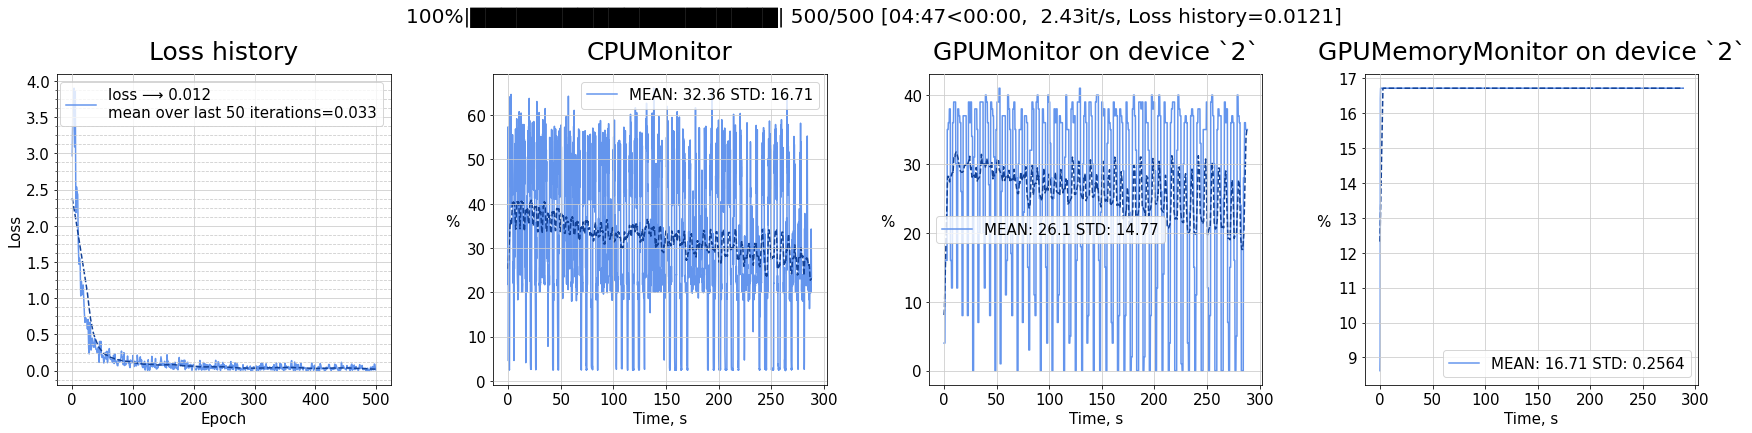

In [10]:
loss_history = []

notifier = Notifier(
    bar='n', frequency=10,
    graphs=[{'source': loss_history, 'name': 'Loss history', 'plot_config': {'xlabel': 'Epoch'}}, 'cpu', 'gpu', 'gpu_memory']
)

N_EPOCHS = 500

for epoch_num in notifier(N_EPOCHS):
    epoch_loss = []
    for batch in train_loader:
        inputs = batch['input_tensors'].to(device)
        embeddings = model(inputs)

        labels = batch['labels'].to(device)
        loss = criterion(embeddings, labels)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss_value = loss.detach().cpu().numpy().flatten()[0]
        epoch_loss.append(loss_value)
    loss_history.append(np.mean(epoch_loss))

In [11]:
model.eval()

train_embeddings = []
train_labels = []

train_loader_ = torch.utils.data.DataLoader(train_dataset, batch_size=16, generator=generator)

for train_batch in Notifier('t')(train_loader_):
    train_inputs = train_batch['input_tensors'].to(device)
    train_batch_embeddings = model(train_inputs).detach().cpu().numpy()
    train_embeddings.append(train_batch_embeddings)
    train_labels.append(train_batch['labels'])
    
train_embeddings = np.vstack(train_embeddings)
train_labels = np.hstack(train_labels)

100%|███████████████████████████████████████████| 72/72 [00:03<00:00, 20.64it/s]


In [12]:
test_dataset = DatasetWithLabels(df=test_df, dataset_root='.', transform=transform, f_imread=imread_pillow)

In [13]:
model.eval()

test_embeddings = []
test_labels = []

test_loader_ = torch.utils.data.DataLoader(test_dataset, batch_size=16, generator=generator)

for test_batch in Notifier('t')(test_loader_):
    test_inputs = test_batch['input_tensors'].to(device)
    test_batch_embeddings = model(test_inputs).detach().cpu().numpy()
    test_embeddings.append(test_batch_embeddings)
    test_labels.append(test_batch['labels'])
    
test_embeddings = np.vstack(test_embeddings)
test_labels = np.hstack(test_labels)

100%|███████████████████████████████████████████| 18/18 [00:00<00:00, 18.31it/s]


In [51]:
MODEL_PATH = f'../models/{NAME}.state'
# torch.save(model.state_dict(), MODEL_PATH)

In [39]:
%%time

diff = ((train_embeddings.reshape(1137, 1, 1000) - test_embeddings) ** 2).mean(axis=-1)
closest = train_labels[diff.argsort(axis=0)][:30].T
offsets = closest + np.arange(closest.shape[0])[:, None] * n_classes
counts = np.bincount(offsets.ravel(), minlength=closest.shape[0] * n_classes)
counts = counts.reshape(-1, n_classes)
test_predictions = counts.argmax(axis=1)

CPU times: user 416 ms, sys: 240 ms, total: 656 ms
Wall time: 656 ms


In [40]:
from batchflow.models.metrics import ClassificationMetrics

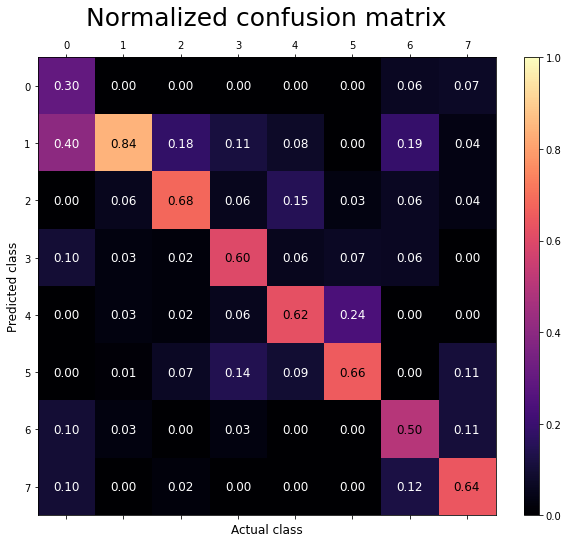

In [41]:
metrics = ClassificationMetrics(test_labels, test_predictions, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [42]:
labels, counts = np.unique(train_labels, return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame(data={'counts': counts, 'shares': shares, **metrics_dict}, index=label_encoder.classes_)

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=['shares', *metrics_names])

,counts,shares,precision,recall
ArtDeco,55,4%,50%,30%
Cubism,295,25%,71%,84%
Impressionism,196,17%,63%,68%
Japonism,168,14%,67%,60%
Naturalism,165,14%,73%,62%
Rococo,88,7%,52%,65%
cartoon,59,5%,53%,50%
photo,111,9%,81%,64%


In [43]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,67%,62%


In [50]:
METRICS_PATH = f'../metrics/{NAME}.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
# np.save(METRICS_PATH, all_metrics)